# Montar las carpetas de google drive.
# Create environment in Google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Move to google drive environment
%cd /content/drive/MyDrive/TFM Comparativa Soluciones

/content/drive/MyDrive/TFM Comparativa Soluciones


In [ ]:
! unzip train.zip

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: train/ISIC_6961482.jpg  
  inflating: __MACOSX/train/._ISIC_6961482.jpg  
  inflating: train/ISIC_0528791.jpg  
  inflating: __MACOSX/train/._ISIC_0528791.jpg  
  inflating: train/ISIC_6900068.jpg  
  inflating: __MACOSX/train/._ISIC_6900068.jpg  
  inflating: train/ISIC_5611010.jpg  
  inflating: __MACOSX/train/._ISIC_5611010.jpg  
  inflating: train/ISIC_2776986.jpg  
  inflating: __MACOSX/train/._ISIC_2776986.jpg  
  inflating: train/ISIC_1860049.jpg  
  inflating: __MACOSX/train/._ISIC_1860049.jpg  
  inflating: train/ISIC_8214363.jpg  
  inflating: __MACOSX/train/._ISIC_8214363.jpg  
  inflating: train/ISIC_3632547.jpg  
  inflating: __MACOSX/train/._ISIC_3632547.jpg  
  inflating: train/ISIC_1877535.jpg  
  inflating: __MACOSX/train/._ISIC_1877535.jpg  
  inflating: train/ISIC_9358532.jpg  
  inflating: __MACOSX/train/._ISIC_9358532.jpg  
  inflating: train/ISIC_9660528.jpg  
  inflating: __MACOSX/train/._I

# Funciones para ejecutar el código

In [ ]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
from skimage import io

#!pip install efficientnet_pytorch torchtoolbox
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
#import torchtoolbox.transform as transforms

import torchvision
from torchvision import datasets, models, transforms

from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, GroupKFold
import gc
import cv2
import time
import datetime
import warnings
import random
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
%matplotlib inline

from PIL import Image
from IPython.display import FileLink 

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

import seaborn as sns
import matplotlib.pyplot as pl

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def make_CNN(model_name, num_classes):
    # Initialize these variables which will be set in this if statement. Each of these
    # variables is model specific.
    # The model (nn.Module) to return
    model_ft = None
    # The input image is expected to be (input_size, input_size)
    input_size = 0
    
    # You may NOT use pretrained models!! 
    use_pretrained = False
    
    # By default, all parameters will be trained (useful when you're starting from scratch)
    # Within this function you can set .requires_grad = False for various parameters, if you don't want to learn them

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, 1)
        input_size = 224
        
    elif model_name == "vgg16":
        """ VGG16_bn
        """
        model_ft = models.vgg16_bn(pretrained=use_pretrained)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs, 1)
        input_size = 224       

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        model_ft.classifier[1] = nn.Conv2d(512, 1, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, 1)
        input_size = 224
        
    else:
        raise Exception("Invalid model name!")
    
    return model_ft, input_size

In [ ]:
class Melanoma_Net(nn.Module):
    """
    fc1: number of neurons in the hidden fully connected layer
    """
    def __init__(self, cnn_model_name, num_classes, num_multimodal_features=9, fc1_out=32):
        #num_classes = 1
        #num_multimodal_features= 9
        super(Melanoma_Net, self).__init__()
        self.cnn, self.input_size = make_CNN(cnn_model_name, num_classes)#models.vgg11(pretrained=False, progress = True)
        #define output layers
        self.fc1 = nn.Linear(num_classes + num_multimodal_features, fc1_out) #takes in input of CNN and multimodal input
        self.fc2 = nn.Linear(fc1_out, num_classes)
        
    def forward(self, image, data):
        x1 = self.cnn(image)
        #print("x1", x1.shape)
        x2 = data
        #print("x2", x2.shape)
        #print("x1: ", x1, type(x1))
        #print("x2: ", x2, type(x2))
        #x = torch.cat((x1, x2), dim=1)  
        x = torch.cat((x1.float(), x2.float()), dim=1) ### ???

        #print("concat", x.shape)
        x = F.relu(self.fc1(x))
        #print("relu", x.shape)
        x = self.fc2(x)
        #print('forward output: ', x)
        #print("fc2", x.shape)
        return x.double() ### ???

In [ ]:
class AdvancedHairAugmentation:
    """
    Impose an image of a hair to the target image

    Args:
        hairs (int): maximum number of hairs to impose
        hairs_folder (str): path to the folder with hairs images
    """

    def __init__(self, hairs: int = 5, hairs_folder: str = ""):
        self.hairs = hairs
        self.hairs_folder = hairs_folder

    def __call__(self, img_path):
        """
        Args:
            img (PIL Image): Image to draw hairs on.

        Returns:
            PIL Image: Image with drawn hairs.
        """
        img = cv2.imread(img_path)
        n_hairs = random.randint(1, self.hairs)
        
        if not n_hairs:
            return img
        
        height, width, _ = img.shape  # target image width and height
        hair_images = [im for im in os.listdir(self.hairs_folder) if 'png' in im]
        
        for _ in range(n_hairs):
            hair = cv2.imread(os.path.join(self.hairs_folder, random.choice(hair_images)))
            hair = cv2.flip(hair, random.choice([-1, 0, 1]))
            hair = cv2.rotate(hair, random.choice([0, 1, 2]))

            h_height, h_width, _ = hair.shape  # hair image width and height
            roi_ho = random.randint(0, img.shape[0] - hair.shape[0])
            roi_wo = random.randint(0, img.shape[1] - hair.shape[1])
            roi = img[roi_ho:roi_ho + h_height, roi_wo:roi_wo + h_width]

            # Creating a mask and inverse mask
            img2gray = cv2.cvtColor(hair, cv2.COLOR_BGR2GRAY)
            ret, mask = cv2.threshold(img2gray, 10, 255, cv2.THRESH_BINARY)
            mask_inv = cv2.bitwise_not(mask)

            # Now black-out the area of hair in ROI
            img_bg = cv2.bitwise_and(roi, roi, mask=mask_inv)

            # Take only region of hair from hair image.
            hair_fg = cv2.bitwise_and(hair, hair, mask=mask)

            # Put hair in ROI and modify the target image
            dst = cv2.add(img_bg, hair_fg)

            img[roi_ho:roi_ho + h_height, roi_wo:roi_wo + h_width] = dst
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #converts image color back to regular color (instead of producing blue tinted image)        
        return img

    def __repr__(self):
        return f'{self.__class__.__name__}(hairs={self.hairs}, hairs_folder="{self.hairs_folder}")'

In [ ]:
class MultimodalDataset(Dataset):
    """
    Custom dataset definition
    """
    def __init__(self, csv_path, img_path, mode='train', transform=None):
        """
        """
        self.df = pd.read_csv(csv_path)
        self.img_path = img_path
        self.mode= mode
        self.transform = transform
        
            
    def __getitem__(self, index):
        """
        """
        img_name = self.df.iloc[index]["image_name"] + ".jpg"
        img_path = os.path.join(self.img_path, img_name)
        image = Image.open(img_path)

        dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor # ???
        
        if self.mode == 'train':
            #augments malignant images with hair twice
            if self.df.iloc[index]["augmented"]==1:
                image = AdvancedHairAugmentation(hairs_folder="melanoma_hairs")(img_path)
                image = Image.fromarray(image, 'RGB')
            elif self.df.iloc[index]["augmented"]==2:
                image = AdvancedHairAugmentation(hairs_folder="melanoma_hairs")(img_path)
                image = Image.fromarray(image, 'RGB')
            else:  
                image = image.convert("RGB")
                
            image = np.asarray(image)
            if self.transform is not None:
                image = self.transform(image)
            labels = torch.tensor(self.df.iloc[index]["target"], dtype = torch.float64)
            
            features = np.fromstring(self.df.iloc[index]["features"][1:-1], sep=",") #turns features into an array            
            features = torch.from_numpy(features.astype("float")) #turns the features array into a vector
            return image, features, labels
            
        elif self.mode == 'val':
            image = np.asarray(image)
            if self.transform is not None:
                image = self.transform(image)
            labels = torch.tensor(self.df.iloc[index]["target"], dtype = torch.float64)
            
            features = np.fromstring(self.df.iloc[index]["features"][1:-1], sep=",") #turns features into an array
            features = torch.from_numpy(features.astype("float")) #turns the features array into a vector
            return image, features, labels
        
        else: #when self.mode=='test'
            image = np.asarray(image)
            if self.transform is not None:
                image = self.transform(image)
            features = np.fromstring(self.df.iloc[index]["features"][1:-1], sep=",") #turns features into an array
            features = torch.from_numpy(features.astype("float")) #turns the features array into a vector
            return image, features, self.df.iloc[index]["image_name"]

    def __len__(self):
        return len(self.df)

In [ ]:
image_path_dict = {'train': "train",
                  'val': "train" ,
                  'test': "train"}

dataframes_path = 'melanoma_without_duplicates_separated/'

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, logits=False, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduce=False)
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduce=False)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

In [ ]:
def make_optimizer(model):
    #Get all the parameters
    params_to_update = model.parameters()
    print("Params to learn:")
    for name, param in model.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

    #Use SGD
    optimizer = optim.SGD(params_to_update, lr=0.01, momentum=0.9)
    return optimizer

 
def get_loss(num_classes,device):
    # Create an instance of the loss function
    # We could set weights to account for unbalanced data but we have augmented the data to be even in benign count and malignant count
    
    #pos_weight = torch.tensor(np.ones(num_classes))
    #pos_weight = pos_weight.to(device)
    criterion = nn.BCEWithLogitsLoss()
    
    #criterion = FocalLoss()
    return criterion

In [ ]:
def get_dataloaders(input_size, batch_size, augment=False, shuffle = True):
    # How to transform the image when you are loading them.
    # you'll likely want to mess with the transforms on the training set.
    
    # For now, we resize/crop the image to the correct input size for our network,
    # then convert it to a [C,H,W] tensor, then normalize it to values with a given mean/stdev. These normalization constants
    # are derived from aggregating lots of data and happen to produce better results.
    data_transforms = {
        'train': transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.225])
        ]),
        'val': transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.225])
        ]),
        'test': transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.225])
        ])
    }
    # Create training and validation datasets
    data_subsets = {x: MultimodalDataset(csv_path=dataframes_path + x + ".csv", 
                                         img_path = image_path_dict[x],
                                         mode = x,
                                         transform=data_transforms[x]) for x in data_transforms.keys()}
    
    # Create training and validation dataloaders
    # Never shuffle the test set
    dataloaders_dict = {x: DataLoader(data_subsets[x], batch_size=batch_size, shuffle=False if x != 'train' else shuffle, num_workers=4) for x in data_transforms.keys()}
    return dataloaders_dict

In [ ]:
val_df = pd.read_csv(dataframes_path + "val.csv")
val_real = []
for i in range(val_df.shape[0]):
    val_real.append(val_df['target'].iloc[i])

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, 
                scheduler, model_name=str(datetime.datetime.now()), 
                save_dir = None, num_epochs=25):
    import time
    start_time = time.time()
    
    #take out if just starting to train
    #checkpoint = torch.load("../input/shuffle-meta-conf-matrix/resnet_weights_12.pt")
    #model.load_state_dict(checkpoint['state_dict'])
    #optimizer.load_state_dict(checkpoint['optimizer'])
    #epoch_before = checkpoint['epoch']

    train_losses = []
    test_losses = []
    train_auc=[]
    val_auc=[]
    train_pred = []
    train_real = []
    val_pred = []
    val_real = []
    for epoch in range(num_epochs):

        train_preds=[]
        train_targets=[]
        auc_train=[]
        loss_epoch_train=[]
        loss_epoch_test=[]
        # Run the training batches
        for inputs, features, labels in tqdm(dataloaders['train']):
            inputs = inputs.to(device)
            features = features.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs, features)
            outputs = torch.squeeze(outputs)
            #outputs = torch.as_tensor(outputs.tolist())
            preds = (outputs > 0).type(torch.float64)
            train_real.extend(labels.tolist())
            train_pred.extend(preds.tolist())
            
            labels = torch.squeeze(labels)
            loss = criterion(torch.sigmoid(outputs.type(torch.FloatTensor)), labels.type(torch.FloatTensor))
            loss_epoch_train.append(loss.item())
                
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        auc_train=roc_auc_score(labels.detach().cpu().numpy(),torch.sigmoid(outputs).detach().cpu().numpy())
        #auc_train=roc_auc_score(y_train.detach().to(device).numpy(),torch.sigmoid(y_pred).detach().to(device).numpy())
        
        train_losses.append(np.mean(loss_epoch_train))
        train_auc.append(auc_train)
        
        print(f'Epoch: {epoch:2} Train Loss: {np.mean(loss_epoch_train):10.8f} AUC: {auc_train:10.8f} ')
        df_confusion = confusion_matrix(train_real, train_pred)
        df_conf_norm = df_confusion / df_confusion.sum(axis=1, keepdims = True)
        print(df_conf_norm)
        
        # Run the testing batches
        with torch.no_grad():
            for inputs, features, labels in tqdm(dataloaders['val']):
                inputs = inputs.to(device)
                features = features.to(device)
                labels = labels.to(device)
                
                outputs = model(inputs, features)
                #print('outputs1 ' + str(outputs))

                outputs = torch.squeeze(outputs)
                #print('outputs2 ' + str(outputs))
                preds = (outputs > 0).type(torch.float64)
                #print('labels ' + (str(labels)))
                #print('pred ' + str(preds))
                val_real.extend(labels.tolist())
                val_pred.extend(preds.tolist())
                
                #outputs = torch.as_tensor(outputs.tolist())
                #print('new outs', outputs)
                labels = torch.squeeze(labels)
                loss = criterion(torch.sigmoid(outputs.type(torch.FloatTensor)), labels.type(torch.FloatTensor))
                loss_epoch_test.append(loss.item())
                                          
        auc_val=roc_auc_score(labels.detach().cpu().numpy(),torch.sigmoid(outputs).detach().cpu().numpy())
        
        test_losses.append(np.mean(loss_epoch_test))
        val_auc.append(auc_val)
        
        print(f'Epoch: {epoch} Val Loss: {np.mean(loss_epoch_test):10.8f} AUC: {auc_val:10.8f} ')
        df_confusion = confusion_matrix(val_real, val_pred)
        df_conf_norm = df_confusion / df_confusion.sum(axis=1, keepdims = True)
        print(df_conf_norm)
        
        if epoch % 5==0:
        #if epoch % 5==0:
            model_file = { 'epoch': epoch,
                      'state_dict': model.state_dict(),
                      'optimizer' : optimizer.state_dict()}
            torch.save(model_file, dataframes_path + "Pesos Vgg16/{}_weights_{}.pt".format(model_name, epoch))
        #epoch if just started training
        #epoch + epoch_before + 1 afterwards
    print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed
    return train_auc, val_auc, train_losses,test_losses

In [ ]:
# Models to choose from [resnet, vgg16, squeezenet, densenet]
# You can add your own, or modify these however you wish!
model_name = 'vgg16'

# Number of classes in the dataset
num_classes = 1

# Batch size for training (change depending on how much memory you have)
# You should use a power of 2.
batch_size = 64

# Shuffle the input data?
shuffle_datasets = True

# Number of epochs to train for 
num_epochs = 200

# Directory to save weights to
#save_dir = "weights"
#os.makedirs(save_dir, exist_ok=True)

In [ ]:
# Initialize the model for this run
model = Melanoma_Net(cnn_model_name = model_name, num_classes = num_classes)
input_size = model.input_size
    
dataloaders = get_dataloaders(input_size, batch_size, shuffle = shuffle_datasets)
criterion = get_loss(num_classes=num_classes,device=device)

# Move the model to the gpu if needed
model = model.to(device)

optimizer = make_optimizer(model)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5,10],gamma=0.1)

# Train the model!
train_auc, val_auc,train_losses,test_losses  = train_model(model=model,
            dataloaders=dataloaders, criterion=criterion, optimizer=optimizer,
            scheduler=scheduler, model_name=model_name, num_epochs=num_epochs)

Params to learn:
	 cnn.features.0.weight
	 cnn.features.0.bias
	 cnn.features.1.weight
	 cnn.features.1.bias
	 cnn.features.3.weight
	 cnn.features.3.bias
	 cnn.features.4.weight
	 cnn.features.4.bias
	 cnn.features.7.weight
	 cnn.features.7.bias
	 cnn.features.8.weight
	 cnn.features.8.bias
	 cnn.features.10.weight
	 cnn.features.10.bias
	 cnn.features.11.weight
	 cnn.features.11.bias
	 cnn.features.14.weight
	 cnn.features.14.bias
	 cnn.features.15.weight
	 cnn.features.15.bias
	 cnn.features.17.weight
	 cnn.features.17.bias
	 cnn.features.18.weight
	 cnn.features.18.bias
	 cnn.features.20.weight
	 cnn.features.20.bias
	 cnn.features.21.weight
	 cnn.features.21.bias
	 cnn.features.24.weight
	 cnn.features.24.bias
	 cnn.features.25.weight
	 cnn.features.25.bias
	 cnn.features.27.weight
	 cnn.features.27.bias
	 cnn.features.28.weight
	 cnn.features.28.bias
	 cnn.features.30.weight
	 cnn.features.30.bias
	 cnn.features.31.weight
	 cnn.features.31.bias
	 cnn.features.34.weight
	 cnn.feat

100%|██████████| 27/27 [00:30<00:00,  1.11s/it]


Epoch:  0 Train Loss: 0.72477208 AUC: 0.70686275 
[[0.99098083 0.00901917]
 [0.95362663 0.04637337]]


100%|██████████| 7/7 [00:03<00:00,  1.93it/s]


Epoch: 0 Val Loss: 0.72539341 AUC: 0.52941176 
[[0.95495495 0.04504505]
 [0.96190476 0.03809524]]


100%|██████████| 27/27 [00:30<00:00,  1.11s/it]


Epoch:  1 Train Loss: 0.70763964 AUC: 0.90196078 
[[0.95828636 0.04171364]
 [0.76575505 0.23424495]]


100%|██████████| 7/7 [00:03<00:00,  1.84it/s]


Epoch: 1 Val Loss: 0.71773412 AUC: 0.68311195 
[[0.88963964 0.11036036]
 [0.79047619 0.20952381]]


100%|██████████| 27/27 [00:29<00:00,  1.08s/it]


Epoch:  2 Train Loss: 0.66030575 AUC: 0.87389163 
[[0.92972567 0.07027433]
 [0.61395164 0.38604836]]


100%|██████████| 7/7 [00:03<00:00,  1.79it/s]


Epoch: 2 Val Loss: 0.67337894 AUC: 0.76660342 
[[0.87537538 0.12462462]
 [0.72063492 0.27936508]]


100%|██████████| 27/27 [00:29<00:00,  1.09s/it]


Epoch:  3 Train Loss: 0.60773175 AUC: 0.81329423 
[[0.91967306 0.08032694]
 [0.54161712 0.45838288]]


100%|██████████| 7/7 [00:03<00:00,  1.89it/s]


Epoch: 3 Val Loss: 0.64780233 AUC: 0.77419355 
[[0.84797297 0.15202703]
 [0.62380952 0.37619048]]


100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


Epoch:  4 Train Loss: 0.59853779 AUC: 0.86314761 
[[0.91431793 0.08568207]
 [0.4941736  0.5058264 ]]


100%|██████████| 7/7 [00:03<00:00,  1.87it/s]


Epoch: 4 Val Loss: 0.64960494 AUC: 0.78178368 
[[0.84144144 0.15855856]
 [0.58666667 0.41333333]]


100%|██████████| 27/27 [00:29<00:00,  1.09s/it]


Epoch:  5 Train Loss: 0.59850199 AUC: 0.86568627 
[[0.90736565 0.09263435]
 [0.45798652 0.54201348]]


100%|██████████| 7/7 [00:03<00:00,  1.88it/s]


Epoch: 5 Val Loss: 0.66145364 AUC: 0.70208729 
[[0.83183183 0.16816817]
 [0.56904762 0.43095238]]


100%|██████████| 27/27 [00:29<00:00,  1.09s/it]


Epoch:  6 Train Loss: 0.59235561 AUC: 0.95196078 
[[0.90819778 0.09180222]
 [0.43485646 0.56514354]]


100%|██████████| 7/7 [00:03<00:00,  1.89it/s]


Epoch: 6 Val Loss: 0.64399863 AUC: 0.79316888 
[[0.82561133 0.17438867]
 [0.54217687 0.45782313]]


100%|██████████| 27/27 [00:29<00:00,  1.09s/it]


Epoch:  7 Train Loss: 0.59372758 AUC: 0.86408730 
[[0.90684893 0.09315107]
 [0.41587396 0.58412604]]


100%|██████████| 7/7 [00:03<00:00,  1.84it/s]


Epoch: 7 Val Loss: 0.66620456 AUC: 0.76660342 
[[0.82038288 0.17961712]
 [0.53869048 0.46130952]]


100%|██████████| 27/27 [00:29<00:00,  1.09s/it]


Epoch:  8 Train Loss: 0.59012001 AUC: 0.91593353 
[[0.90692722 0.09307278]
 [0.40137403 0.59862597]]


100%|██████████| 7/7 [00:03<00:00,  1.93it/s]


Epoch: 8 Val Loss: 0.65289877 AUC: 0.81024668 
[[0.81781782 0.18218218]
 [0.52592593 0.47407407]]


100%|██████████| 27/27 [00:29<00:00,  1.09s/it]


Epoch:  9 Train Loss: 0.59106334 AUC: 0.95589744 
[[0.90676437 0.09323563]
 [0.3901308  0.6098692 ]]


100%|██████████| 7/7 [00:03<00:00,  1.89it/s]


Epoch: 9 Val Loss: 0.65359142 AUC: 0.79506641 
[[0.81711712 0.18288288]
 [0.52047619 0.47952381]]


100%|██████████| 27/27 [00:29<00:00,  1.09s/it]


Epoch: 10 Train Loss: 0.58691511 AUC: 0.95210166 
[[0.9091934  0.0908066 ]
 [0.38287753 0.61712247]]


100%|██████████| 7/7 [00:03<00:00,  1.88it/s]


Epoch: 10 Val Loss: 0.65998404 AUC: 0.77039848 
[[0.82268632 0.17731368]
 [0.52857143 0.47142857]]


100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


Epoch: 11 Train Loss: 0.59245314 AUC: 0.93750000 
[[0.91018414 0.08981586]
 [0.3780222  0.6219778 ]]


100%|██████████| 7/7 [00:03<00:00,  1.83it/s]


Epoch: 11 Val Loss: 0.66801545 AUC: 0.77609108 
[[0.81681682 0.18318318]
 [0.52460317 0.47539683]]


100%|██████████| 27/27 [00:29<00:00,  1.09s/it]


Epoch: 12 Train Loss: 0.58463711 AUC: 0.85813492 
[[0.91258347 0.08741653]
 [0.37336504 0.62663496]]


100%|██████████| 7/7 [00:03<00:00,  1.83it/s]


Epoch: 12 Val Loss: 0.65025004 AUC: 0.79127135 
[[0.81150381 0.18849619]
 [0.50879121 0.49120879]]


100%|██████████| 27/27 [00:29<00:00,  1.09s/it]


Epoch: 13 Train Loss: 0.58109385 AUC: 0.92019704 
[[0.91351264 0.08648736]
 [0.36606081 0.63393919]]


100%|██████████| 7/7 [00:03<00:00,  1.86it/s]


Epoch: 13 Val Loss: 0.65802876 AUC: 0.81024668 
[[0.8018018 0.1981982]
 [0.4914966 0.5085034]]


100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


Epoch: 14 Train Loss: 0.58781478 AUC: 0.91428571 
[[0.91311537 0.08688463]
 [0.36044392 0.63955608]]


100%|██████████| 7/7 [00:03<00:00,  1.89it/s]


Epoch: 14 Val Loss: 0.64855791 AUC: 0.79506641 
[[0.8009009  0.1990991 ]
 [0.48634921 0.51365079]]


100%|██████████| 27/27 [00:29<00:00,  1.09s/it]


Epoch: 15 Train Loss: 0.58205509 AUC: 0.92179863 
[[0.91382469 0.08617531]
 [0.35471165 0.64528835]]


100%|██████████| 7/7 [00:03<00:00,  1.84it/s]


Epoch: 15 Val Loss: 0.65811365 AUC: 0.77988615 
[[0.80152027 0.19847973]
 [0.4875     0.5125    ]]


100%|██████████| 27/27 [00:29<00:00,  1.09s/it]


Epoch: 16 Train Loss: 0.58550016 AUC: 0.93750000 
[[0.91670535 0.08329465]
 [0.35475974 0.64524026]]


100%|██████████| 7/7 [00:03<00:00,  1.81it/s]


Epoch: 16 Val Loss: 0.66675044 AUC: 0.74383302 
[[0.80074192 0.19925808]
 [0.48795518 0.51204482]]


100%|██████████| 27/27 [00:29<00:00,  1.09s/it]


Epoch: 17 Train Loss: 0.58039518 AUC: 0.90713587 
[[0.91838908 0.08161092]
 [0.35182983 0.64817017]]


100%|██████████| 7/7 [00:03<00:00,  1.89it/s]


Epoch: 17 Val Loss: 0.66520177 AUC: 0.73434535 
[[0.7967968  0.2032032 ]
 [0.48201058 0.51798942]]


100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


Epoch: 18 Train Loss: 0.57717896 AUC: 0.90376984 
[[0.91936154 0.08063846]
 [0.34720571 0.65279429]]


100%|██████████| 7/7 [00:03<00:00,  1.88it/s]


Epoch: 18 Val Loss: 0.64425077 AUC: 0.84060721 
[[0.79753438 0.20246562]
 [0.47869674 0.52130326]]


100%|██████████| 27/27 [00:29<00:00,  1.09s/it]


Epoch: 19 Train Loss: 0.57842186 AUC: 0.98533724 
[[0.92136415 0.07863585]
 [0.34512485 0.65487515]]


100%|██████████| 7/7 [00:03<00:00,  1.86it/s]


Epoch: 19 Val Loss: 0.65260071 AUC: 0.88425047 
[[0.79121622 0.20878378]
 [0.46666667 0.53333333]]


100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


Epoch: 20 Train Loss: 0.57996627 AUC: 0.91300098 
[[0.92188758 0.07811242]
 [0.34199649 0.65800351]]


100%|██████████| 7/7 [00:03<00:00,  1.86it/s]


Epoch: 20 Val Loss: 0.66523410 AUC: 0.74952562 
[[0.7953668  0.2046332 ]
 [0.47505669 0.52494331]]


100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


Epoch: 21 Train Loss: 0.57457728 AUC: 0.94778325 
[[0.9232346  0.0767654 ]
 [0.33915252 0.66084748]]


100%|██████████| 7/7 [00:03<00:00,  1.88it/s]


Epoch: 21 Val Loss: 0.65492449 AUC: 0.75711575 
[[0.7964783  0.2035217 ]
 [0.47467532 0.52532468]]


100%|██████████| 27/27 [00:29<00:00,  1.09s/it]


Epoch: 22 Train Loss: 0.57381567 AUC: 0.84946237 
[[0.92529778 0.07470222]
 [0.33779662 0.66220338]]


100%|██████████| 7/7 [00:03<00:00,  1.82it/s]


Epoch: 22 Val Loss: 0.66208776 AUC: 0.70018975 
[[0.79455542 0.20544458]
 [0.47142857 0.52857143]]


100%|██████████| 27/27 [00:29<00:00,  1.08s/it]


Epoch: 23 Train Loss: 0.57179373 AUC: 0.92941176 
[[0.92709508 0.07290492]
 [0.33586009 0.66413991]]


100%|██████████| 7/7 [00:03<00:00,  1.85it/s]


Epoch: 23 Val Loss: 0.65579440 AUC: 0.76280835 
[[0.79485736 0.20514264]
 [0.47202381 0.52797619]]


100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


Epoch: 24 Train Loss: 0.57558151 AUC: 0.86011905 
[[0.92744081 0.07255919]
 [0.33269917 0.66730083]]


100%|██████████| 7/7 [00:03<00:00,  1.91it/s]


Epoch: 24 Val Loss: 0.66411552 AUC: 0.77039848 
[[0.79225225 0.20774775]
 [0.46990476 0.53009524]]


100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


Epoch: 25 Train Loss: 0.57050271 AUC: 0.94232649 
[[0.92802012 0.07197988]
 [0.32900393 0.67099607]]


100%|██████████| 7/7 [00:03<00:00,  1.85it/s]


Epoch: 25 Val Loss: 0.65350331 AUC: 0.72675522 
[[0.79400554 0.20599446]
 [0.47087912 0.52912088]]


100%|██████████| 27/27 [00:30<00:00,  1.13s/it]


Epoch: 26 Train Loss: 0.56857382 AUC: 0.98144531 
[[0.92980918 0.07019082]
 [0.32743207 0.67256793]]


100%|██████████| 7/7 [00:03<00:00,  1.86it/s]


Epoch: 26 Val Loss: 0.65321988 AUC: 0.74952562 
[[0.79279279 0.20720721]
 [0.46666667 0.53333333]]


100%|██████████| 27/27 [00:29<00:00,  1.09s/it]


Epoch: 27 Train Loss: 0.57156731 AUC: 0.91791792 
[[0.93054437 0.06945563]
 [0.32520809 0.67479191]]


100%|██████████| 7/7 [00:03<00:00,  1.84it/s]


Epoch: 27 Val Loss: 0.66005050 AUC: 0.68690702 
[[0.79198842 0.20801158]
 [0.46462585 0.53537415]]


100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


Epoch: 28 Train Loss: 0.56690982 AUC: 0.91191191 
[[0.93192862 0.06807138]
 [0.32326049 0.67673951]]


100%|██████████| 7/7 [00:03<00:00,  1.83it/s]


Epoch: 28 Val Loss: 0.64369445 AUC: 0.79886148 
[[0.79419074 0.20580926]
 [0.46518883 0.53481117]]


100%|██████████| 27/27 [00:29<00:00,  1.08s/it]


Epoch: 29 Train Loss: 0.56485657 AUC: 0.90518084 
[[0.93337091 0.06662909]
 [0.32088783 0.67911217]]


100%|██████████| 7/7 [00:03<00:00,  1.89it/s]


Epoch: 29 Val Loss: 0.65433898 AUC: 0.67172676 
[[0.79384384 0.20615616]
 [0.46333333 0.53666667]]


100%|██████████| 27/27 [00:29<00:00,  1.09s/it]


Epoch: 30 Train Loss: 0.56867119 AUC: 0.92615385 
[[0.93395643 0.06604357]
 [0.31847647 0.68152353]]


100%|██████████| 7/7 [00:03<00:00,  1.84it/s]


Epoch: 30 Val Loss: 0.65058523 AUC: 0.66603416 
[[0.79569892 0.20430108]
 [0.46466974 0.53533026]]


100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


Epoch: 31 Train Loss: 0.56891075 AUC: 0.97832512 
[[0.93513952 0.06486048]
 [0.31751635 0.68248365]]


100%|██████████| 7/7 [00:03<00:00,  1.86it/s]


Epoch: 31 Val Loss: 0.64267971 AUC: 0.75711575 
[[0.79546734 0.20453266]
 [0.4610119  0.5389881 ]]


100%|██████████| 27/27 [00:29<00:00,  1.09s/it]


Epoch: 32 Train Loss: 0.56256552 AUC: 0.90871795 
[[0.93611424 0.06388576]
 [0.3152452  0.6847548 ]]


100%|██████████| 7/7 [00:03<00:00,  1.82it/s]


Epoch: 32 Val Loss: 0.65030410 AUC: 0.62618596 
[[0.7952498  0.2047502 ]
 [0.45887446 0.54112554]]


100%|██████████| 27/27 [00:29<00:00,  1.09s/it]


Epoch: 33 Train Loss: 0.55980831 AUC: 0.95294118 
[[0.93713111 0.06286889]
 [0.31279289 0.68720711]]


100%|██████████| 7/7 [00:03<00:00,  1.85it/s]


Epoch: 33 Val Loss: 0.64832763 AUC: 0.78368121 
[[0.79425013 0.20574987]
 [0.45602241 0.54397759]]


100%|██████████| 27/27 [00:29<00:00,  1.09s/it]


Epoch: 34 Train Loss: 0.55722453 AUC: 0.97536946 
[[0.93754228 0.06245772]
 [0.30912179 0.69087821]]


100%|██████████| 7/7 [00:03<00:00,  1.88it/s]


Epoch: 34 Val Loss: 0.65027618 AUC: 0.72106262 
[[0.79472329 0.20527671]
 [0.45578231 0.54421769]]


100%|██████████| 27/27 [00:29<00:00,  1.09s/it]


Epoch: 35 Train Loss: 0.56626429 AUC: 0.96899225 
[[0.93824377 0.06175623]
 [0.30733915 0.69266085]]


100%|██████████| 7/7 [00:03<00:00,  1.86it/s]


Epoch: 35 Val Loss: 0.64291554 AUC: 0.74383302 
[[0.79654655 0.20345345]
 [0.45687831 0.54312169]]


100%|██████████| 27/27 [00:29<00:00,  1.09s/it]


Epoch: 36 Train Loss: 0.55929327 AUC: 0.96650246 
[[0.93918157 0.06081843]
 [0.30526722 0.69473278]]


100%|██████████| 7/7 [00:03<00:00,  1.82it/s]


Epoch: 36 Val Loss: 0.63936352 AUC: 0.82732448 
[[0.79522766 0.20477234]
 [0.45173745 0.54826255]]


100%|██████████| 27/27 [00:29<00:00,  1.09s/it]


Epoch: 37 Train Loss: 0.55508262 AUC: 0.92843137 
[[0.94015902 0.05984098]
 [0.30258464 0.69741536]]


100%|██████████| 7/7 [00:03<00:00,  1.81it/s]


Epoch: 37 Val Loss: 0.66738140 AUC: 0.75711575 
[[0.79125178 0.20874822]
 [0.44611529 0.55388471]]


100%|██████████| 27/27 [00:29<00:00,  1.09s/it]


Epoch: 38 Train Loss: 0.55837875 AUC: 0.97395833 
[[0.94102853 0.05897147]
 [0.3006799  0.6993201 ]]


100%|██████████| 7/7 [00:03<00:00,  1.85it/s]


Epoch: 38 Val Loss: 0.65317641 AUC: 0.80360531 
[[0.78886579 0.21113421]
 [0.44139194 0.55860806]]


100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


Epoch: 39 Train Loss: 0.55572568 AUC: 0.94433594 
[[0.9416009  0.0583991 ]
 [0.29806778 0.70193222]]


100%|██████████| 7/7 [00:03<00:00,  1.80it/s]


Epoch: 39 Val Loss: 0.63844832 AUC: 0.79316888 
[[0.78963964 0.21036036]
 [0.43952381 0.56047619]]


100%|██████████| 27/27 [00:29<00:00,  1.08s/it]


Epoch: 40 Train Loss: 0.55068795 AUC: 0.96386719 
[[0.94244782 0.05755218]
 [0.29526406 0.70473594]]


100%|██████████| 7/7 [00:03<00:00,  1.90it/s]


Epoch: 40 Val Loss: 0.66816877 AUC: 0.79886148 
[[0.78576137 0.21423863]
 [0.43437863 0.56562137]]


100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


Epoch: 41 Train Loss: 0.55516666 AUC: 0.95898438 
[[0.94277125 0.05722875]
 [0.29262216 0.70737784]]


100%|██████████| 7/7 [00:03<00:00,  1.82it/s]


Epoch: 41 Val Loss: 0.64235068 AUC: 0.77039848 
[[0.78399828 0.21600172]
 [0.42959184 0.57040816]]


100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


Epoch: 42 Train Loss: 0.55456240 AUC: 0.97297297 
[[0.94307963 0.05692037]
 [0.28990958 0.71009042]]


100%|██████████| 7/7 [00:03<00:00,  1.84it/s]


Epoch: 42 Val Loss: 0.63727096 AUC: 0.87286528 
[[0.78378378 0.21621622]
 [0.42657807 0.57342193]]


100%|██████████| 27/27 [00:29<00:00,  1.09s/it]


Epoch: 43 Train Loss: 0.55353558 AUC: 0.96176471 
[[0.94345086 0.05654914]
 [0.28740136 0.71259864]]


100%|██████████| 7/7 [00:03<00:00,  1.82it/s]


Epoch: 43 Val Loss: 0.64929976 AUC: 0.82922201 
[[0.78122441 0.21877559]
 [0.42132035 0.57867965]]


100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


Epoch: 44 Train Loss: 0.55358410 AUC: 0.94901961 
[[0.94383064 0.05616936]
 [0.28492535 0.71507465]]


100%|██████████| 7/7 [00:03<00:00,  1.83it/s]


Epoch: 44 Val Loss: 0.65060375 AUC: 0.75332068 
[[0.78068068 0.21931932]
 [0.41989418 0.58010582]]


100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


Epoch: 45 Train Loss: 0.55602857 AUC: 0.93849206 
[[0.94434096 0.05565904]
 [0.28307398 0.71692602]]


100%|██████████| 7/7 [00:03<00:00,  1.79it/s]


Epoch: 45 Val Loss: 0.69684581 AUC: 0.67172676 
[[0.7773208  0.2226792 ]
 [0.41873706 0.58126294]]


100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


Epoch: 46 Train Loss: 0.54886171 AUC: 1.00000000 
[[0.94509343 0.05490657]
 [0.2809472  0.7190528 ]]


100%|██████████| 7/7 [00:03<00:00,  1.87it/s]


Epoch: 46 Val Loss: 0.64010058 AUC: 0.86527514 
[[0.77630822 0.22369178]
 [0.41499493 0.58500507]]


100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


Epoch: 47 Train Loss: 0.54894704 AUC: 0.98921569 
[[0.94553269 0.05446731]
 [0.27848791 0.72151209]]


100%|██████████| 7/7 [00:03<00:00,  1.84it/s]


Epoch: 47 Val Loss: 0.63949627 AUC: 0.81309298 
[[0.77543168 0.22456832]
 [0.41220238 0.58779762]]


100%|██████████| 27/27 [00:29<00:00,  1.08s/it]


Epoch: 48 Train Loss: 0.54793632 AUC: 0.99120235 
[[0.94604606 0.05395394]
 [0.27622607 0.72377393]]


100%|██████████| 7/7 [00:03<00:00,  1.86it/s]


Epoch: 48 Val Loss: 0.65611526 AUC: 0.85199241 
[[0.77348777 0.22651223]
 [0.4090379  0.5909621 ]]


100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


Epoch: 49 Train Loss: 0.54710274 AUC: 0.98631476 
[[0.94669673 0.05330327]
 [0.27414982 0.72585018]]


100%|██████████| 7/7 [00:03<00:00,  1.89it/s]


Epoch: 49 Val Loss: 0.64302404 AUC: 0.83681214 
[[0.77243243 0.22756757]
 [0.40590476 0.59409524]]


100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


Epoch: 50 Train Loss: 0.54585319 AUC: 0.99595142 
[[0.94712293 0.05287707]
 [0.27187522 0.72812478]]


100%|██████████| 7/7 [00:03<00:00,  1.79it/s]


Epoch: 50 Val Loss: 0.64026291 AUC: 0.86527514 
[[0.77159512 0.22840488]
 [0.40261438 0.59738562]]


100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


Epoch: 51 Train Loss: 0.54466982 AUC: 0.97156863 
[[0.94772786 0.05227214]
 [0.26964237 0.73035763]]


100%|██████████| 7/7 [00:03<00:00,  1.81it/s]


Epoch: 51 Val Loss: 0.63745740 AUC: 0.74573055 
[[0.7731289  0.2268711 ]
 [0.40311355 0.59688645]]


100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


Epoch: 52 Train Loss: 0.54984050 AUC: 0.97230769 
[[0.94811853 0.05188147]
 [0.26771813 0.73228187]]


100%|██████████| 7/7 [00:03<00:00,  1.88it/s]


Epoch: 52 Val Loss: 0.64094137 AUC: 0.82068311 
[[0.77265001 0.22734999]
 [0.40071878 0.59928122]]


100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


Epoch: 53 Train Loss: 0.54732453 AUC: 0.96679688 
[[0.94853647 0.05146353]
 [0.26582111 0.73417889]]


100%|██████████| 7/7 [00:03<00:00,  1.92it/s]


Epoch: 53 Val Loss: 0.63231679 AUC: 0.81973435 
[[0.77218886 0.22781114]
 [0.39744268 0.60255732]]


100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


Epoch: 54 Train Loss: 0.54804828 AUC: 0.96383187 
[[0.94873424 0.05126576]
 [0.26366879 0.73633121]]


100%|██████████| 7/7 [00:03<00:00,  1.81it/s]


Epoch: 54 Val Loss: 0.63650460 AUC: 0.77039848 
[[0.77338247 0.22661753]
 [0.39748918 0.60251082]]


100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


Epoch: 55 Train Loss: 0.54405545 AUC: 0.97947214 
[[0.94912627 0.05087373]
 [0.26150841 0.73849159]]


100%|██████████| 7/7 [00:03<00:00,  1.85it/s]


Epoch: 55 Val Loss: 0.63859743 AUC: 0.77798861 
[[0.77405084 0.22594916]
 [0.39727891 0.60272109]]


100%|██████████| 27/27 [00:29<00:00,  1.11s/it]


Epoch: 56 Train Loss: 0.54605794 AUC: 0.95294118 
[[0.94968255 0.05031745]
 [0.25984104 0.74015896]]


100%|██████████| 7/7 [00:03<00:00,  1.89it/s]


Epoch: 56 Val Loss: 0.63876136 AUC: 0.83491461 
[[0.77358938 0.22641062]
 [0.39540518 0.60459482]]


100%|██████████| 27/27 [00:29<00:00,  1.08s/it]


Epoch: 57 Train Loss: 0.54339083 AUC: 0.99199199 
[[0.95004471 0.04995529]
 [0.25780065 0.74219935]]


100%|██████████| 7/7 [00:04<00:00,  1.75it/s]


Epoch: 57 Val Loss: 0.63870370 AUC: 0.82732448 
[[0.77368748 0.22631252]
 [0.39425287 0.60574713]]


100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


Epoch: 58 Train Loss: 0.54711938 AUC: 0.97339901 
[[0.95035637 0.04964363]
 [0.25607126 0.74392874]]


100%|██████████| 7/7 [00:03<00:00,  1.79it/s]


Epoch: 58 Val Loss: 0.65956719 AUC: 0.81404175 
[[0.77317148 0.22682852]
 [0.39443099 0.60556901]]


100%|██████████| 27/27 [00:29<00:00,  1.09s/it]


Epoch: 59 Train Loss: 0.54882325 AUC: 0.96470588 
[[0.95058249 0.04941751]
 [0.25434007 0.74565993]]


100%|██████████| 7/7 [00:03<00:00,  1.82it/s]


Epoch: 59 Val Loss: 0.64091181 AUC: 0.85578748 
[[0.77177177 0.22822823]
 [0.39166667 0.60833333]]


100%|██████████| 27/27 [00:29<00:00,  1.09s/it]


Epoch: 60 Train Loss: 0.54437290 AUC: 0.97843137 
[[0.95102297 0.04897703]
 [0.25272412 0.74727588]]


100%|██████████| 7/7 [00:03<00:00,  1.85it/s]


Epoch: 60 Val Loss: 0.64239855 AUC: 0.81973435 
[[0.77056565 0.22943435]
 [0.38813427 0.61186573]]


100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


Epoch: 61 Train Loss: 0.54205061 AUC: 0.97339901 
[[0.95121286 0.04878714]
 [0.25056576 0.74943424]]


100%|██████████| 7/7 [00:03<00:00,  1.78it/s]


Epoch: 61 Val Loss: 0.63754058 AUC: 0.81214421 
[[0.77048823 0.22951177]
 [0.38678955 0.61321045]]


100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


Epoch: 62 Train Loss: 0.54662395 AUC: 0.96484375 
[[0.95136093 0.04863907]
 [0.24877791 0.75122209]]


100%|██████████| 7/7 [00:03<00:00,  1.80it/s]


Epoch: 62 Val Loss: 0.63808800 AUC: 0.84535104 
[[0.77112827 0.22887173]
 [0.38662132 0.61337868]]


100%|██████████| 27/27 [00:29<00:00,  1.08s/it]


Epoch: 63 Train Loss: 0.54997551 AUC: 0.95897436 
[[0.95138106 0.04861894]
 [0.24702735 0.75297265]]


100%|██████████| 7/7 [00:03<00:00,  1.76it/s]


Epoch: 63 Val Loss: 0.66428510 AUC: 0.81593928 
[[0.76844032 0.23155968]
 [0.38311012 0.61688988]]


100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


Epoch: 64 Train Loss: 0.54868908 AUC: 0.98998999 
[[0.9514873  0.0485127 ]
 [0.24551358 0.75448642]]


100%|██████████| 7/7 [00:03<00:00,  1.87it/s]


Epoch: 64 Val Loss: 0.63050747 AUC: 0.84440228 
[[0.76992377 0.23007623]
 [0.38351648 0.61648352]]


100%|██████████| 27/27 [00:29<00:00,  1.09s/it]


Epoch: 65 Train Loss: 0.54845933 AUC: 0.94525904 
[[0.95162447 0.04837553]
 [0.24411775 0.75588225]]


100%|██████████| 7/7 [00:03<00:00,  1.83it/s]


Epoch: 65 Val Loss: 0.62416032 AUC: 0.81214421 
[[0.77027027 0.22972973]
 [0.38167388 0.61832612]]


100%|██████████| 27/27 [00:29<00:00,  1.09s/it]


Epoch: 66 Train Loss: 0.53397954 AUC: 0.97297297 
[[0.9520941 0.0479059]
 [0.2420892 0.7579108]]


100%|██████████| 7/7 [00:03<00:00,  1.82it/s]


Epoch: 66 Val Loss: 0.62730364 AUC: 0.91271347 
[[0.7703375  0.2296625 ]
 [0.37981521 0.62018479]]


100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


Epoch: 67 Train Loss: 0.53921868 AUC: 0.97947214 
[[0.95250017 0.04749983]
 [0.24043506 0.75956494]]


100%|██████████| 7/7 [00:03<00:00,  1.82it/s]


Epoch: 67 Val Loss: 0.62950171 AUC: 0.85009488 
[[0.77033651 0.22966349]
 [0.37808123 0.62191877]]


100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


Epoch: 68 Train Loss: 0.54110617 AUC: 0.99608993 
[[0.95295982 0.04704018]
 [0.23915628 0.76084372]]


100%|██████████| 7/7 [00:03<00:00,  1.81it/s]


Epoch: 68 Val Loss: 0.63587007 AUC: 0.87096774 
[[0.77085781 0.22914219]
 [0.37763975 0.62236025]]


100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


Epoch: 69 Train Loss: 0.54042716 AUC: 0.99803922 
[[0.95318087 0.04681913]
 [0.23748938 0.76251062]]


100%|██████████| 7/7 [00:03<00:00,  1.79it/s]


Epoch: 69 Val Loss: 0.64750624 AUC: 0.86527514 
[[0.76904762 0.23095238]
 [0.37421769 0.62578231]]


100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


Epoch: 70 Train Loss: 0.53705067 AUC: 0.97360704 
[[0.95350684 0.04649316]
 [0.23573546 0.76426454]]


100%|██████████| 7/7 [00:03<00:00,  1.79it/s]


Epoch: 70 Val Loss: 0.63068610 AUC: 0.81309298 
[[0.76906484 0.23093516]
 [0.37243461 0.62756539]]


100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


Epoch: 71 Train Loss: 0.53487112 AUC: 0.99120235 
[[0.9539177  0.0460823 ]
 [0.23398071 0.76601929]]


100%|██████████| 7/7 [00:03<00:00,  1.84it/s]


Epoch: 71 Val Loss: 0.62903762 AUC: 0.83681214 
[[0.76883133 0.23116867]
 [0.37030423 0.62969577]]


100%|██████████| 27/27 [00:29<00:00,  1.09s/it]


Epoch: 72 Train Loss: 0.53592268 AUC: 0.99699700 
[[0.95419376 0.04580624]
 [0.23220888 0.76779112]]


100%|██████████| 7/7 [00:03<00:00,  1.78it/s]


Epoch: 72 Val Loss: 0.63723632 AUC: 0.85483871 
[[0.76860422 0.23139578]
 [0.36888454 0.63111546]]


100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


Epoch: 73 Train Loss: 0.53586462 AUC: 0.95686275 
[[0.95450806 0.04549194]
 [0.23048494 0.76951506]]


100%|██████████| 7/7 [00:03<00:00,  1.81it/s]


Epoch: 73 Val Loss: 0.64070390 AUC: 0.85104364 
[[0.7682615  0.2317385 ]
 [0.36743887 0.63256113]]


100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


Epoch: 74 Train Loss: 0.53430473 AUC: 0.99804497 
[[0.95478392 0.04521608]
 [0.22868014 0.77131986]]


100%|██████████| 7/7 [00:03<00:00,  1.80it/s]


Epoch: 74 Val Loss: 0.64190896 AUC: 0.87096774 
[[0.76678679 0.23321321]
 [0.36444444 0.63555556]]


100%|██████████| 27/27 [00:29<00:00,  1.09s/it]


Epoch: 75 Train Loss: 0.53456744 AUC: 0.96924603 
[[0.95500801 0.04499199]
 [0.22690719 0.77309281]]


100%|██████████| 7/7 [00:03<00:00,  1.80it/s]


Epoch: 75 Val Loss: 0.65183200 AUC: 0.86337761 
[[0.76541015 0.23458985]
 [0.3622807  0.6377193 ]]


100%|██████████| 27/27 [00:30<00:00,  1.12s/it]


Epoch: 76 Train Loss: 0.53400812 AUC: 0.95850202 
[[0.95534342 0.04465658]
 [0.22528839 0.77471161]]


100%|██████████| 7/7 [00:03<00:00,  1.80it/s]


Epoch: 76 Val Loss: 0.63315398 AUC: 0.84060721 
[[0.76500527 0.23499473]
 [0.360235   0.639765  ]]


100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


Epoch: 77 Train Loss: 0.53198602 AUC: 0.95214844 
[[0.95561241 0.04438759]
 [0.2235434  0.7764566 ]]


100%|██████████| 7/7 [00:03<00:00,  1.79it/s]


Epoch: 77 Val Loss: 0.63019716 AUC: 0.87096774 
[[0.76507277 0.23492723]
 [0.35891331 0.64108669]]


100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


Epoch: 78 Train Loss: 0.53284161 AUC: 0.96582031 
[[0.95598875 0.04401125]
 [0.22206836 0.77793164]]


100%|██████████| 7/7 [00:03<00:00,  1.78it/s]


Epoch: 78 Val Loss: 0.64563656 AUC: 0.78937381 
[[0.76513856 0.23486144]
 [0.35871007 0.64128993]]


100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


Epoch: 79 Train Loss: 0.53060008 AUC: 0.98115079 
[[0.95632751 0.04367249]
 [0.22039239 0.77960761]]


100%|██████████| 7/7 [00:03<00:00,  1.79it/s]


Epoch: 79 Val Loss: 0.63722805 AUC: 0.84629981 
[[0.76469595 0.23530405]
 [0.35708333 0.64291667]]


100%|██████████| 27/27 [00:29<00:00,  1.09s/it]


Epoch: 80 Train Loss: 0.52950615 AUC: 0.96676442 
[[0.95664398 0.04335602]
 [0.21862568 0.78137432]]


100%|██████████| 7/7 [00:03<00:00,  1.83it/s]


Epoch: 80 Val Loss: 0.62851993 AUC: 0.80645161 
[[0.76509843 0.23490157]
 [0.35655497 0.64344503]]


100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


Epoch: 81 Train Loss: 0.53400388 AUC: 0.96568627 
[[0.95700773 0.04299227]
 [0.21735158 0.78264842]]


100%|██████████| 7/7 [00:03<00:00,  1.81it/s]


Epoch: 81 Val Loss: 0.62911211 AUC: 0.83491461 
[[0.76609536 0.23390464]
 [0.35691057 0.64308943]]


100%|██████████| 27/27 [00:29<00:00,  1.09s/it]


Epoch: 82 Train Loss: 0.53240151 AUC: 0.99704433 
[[0.95730838 0.04269162]
 [0.21586465 0.78413535]]


100%|██████████| 7/7 [00:03<00:00,  1.80it/s]


Epoch: 82 Val Loss: 0.61770846 AUC: 0.83491461 
[[0.76690546 0.23309454]
 [0.35605278 0.64394722]]


100%|██████████| 27/27 [00:29<00:00,  1.09s/it]


Epoch: 83 Train Loss: 0.52953615 AUC: 0.95937500 
[[0.95761529 0.04238471]
 [0.21434234 0.78565766]]


100%|██████████| 7/7 [00:03<00:00,  1.82it/s]


Epoch: 83 Val Loss: 0.63078960 AUC: 0.83111954 
[[0.76635564 0.23364436]
 [0.35368481 0.64631519]]


100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


Epoch: 84 Train Loss: 0.53042309 AUC: 0.99696356 
[[0.95796804 0.04203196]
 [0.21295377 0.78704623]]


100%|██████████| 7/7 [00:03<00:00,  1.87it/s]


Epoch: 84 Val Loss: 0.61666375 AUC: 0.84440228 
[[0.76751457 0.23248543]
 [0.35383754 0.64616246]]


100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


Epoch: 85 Train Loss: 0.52942139 AUC: 0.94134897 
[[0.95826014 0.04173986]
 [0.21147305 0.78852695]]


100%|██████████| 7/7 [00:03<00:00,  1.80it/s]


Epoch: 85 Val Loss: 0.62598868 AUC: 0.84629981 
[[0.76765137 0.23234863]
 [0.35271318 0.64728682]]


100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


Epoch: 86 Train Loss: 0.52455267 AUC: 0.99479167 
[[0.95862328 0.04137672]
 [0.20986237 0.79013763]]


100%|██████████| 7/7 [00:03<00:00,  1.84it/s]


Epoch: 86 Val Loss: 0.61426359 AUC: 0.84440228 
[[0.76788858 0.23211142]
 [0.35073892 0.64926108]]


100%|██████████| 27/27 [00:29<00:00,  1.11s/it]


Epoch: 87 Train Loss: 0.52641616 AUC: 0.98823529 
[[0.95895255 0.04104745]
 [0.20838288 0.79161712]]


100%|██████████| 7/7 [00:03<00:00,  1.80it/s]


Epoch: 87 Val Loss: 0.62213633 AUC: 0.85768501 
[[0.76832514 0.23167486]
 [0.35005411 0.64994589]]


100%|██████████| 27/27 [00:29<00:00,  1.09s/it]


Epoch: 88 Train Loss: 0.52572257 AUC: 0.97262952 
[[0.95929975 0.04070025]
 [0.20688319 0.79311681]]


100%|██████████| 7/7 [00:03<00:00,  1.76it/s]


Epoch: 88 Val Loss: 0.62516249 AUC: 0.82258065 
[[0.76809394 0.23190606]
 [0.3482076  0.6517924 ]]


100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


Epoch: 89 Train Loss: 0.52441930 AUC: 0.94721408 
[[0.95958913 0.04041087]
 [0.20531114 0.79468886]]


100%|██████████| 7/7 [00:03<00:00,  1.77it/s]


Epoch: 89 Val Loss: 0.63068198 AUC: 0.85483871 
[[0.76801802 0.23198198]
 [0.34703704 0.65296296]]


100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


Epoch: 90 Train Loss: 0.52686161 AUC: 0.99605911 
[[0.95989692 0.04010308]
 [0.20393043 0.79606957]]


100%|██████████| 7/7 [00:03<00:00,  1.79it/s]


Epoch: 90 Val Loss: 0.62950993 AUC: 0.76470588 
[[0.76863677 0.23136323]
 [0.3469911  0.6530089 ]]


100%|██████████| 27/27 [00:29<00:00,  1.11s/it]


Epoch: 91 Train Loss: 0.52738918 AUC: 0.98511905 
[[0.96018578 0.03981422]
 [0.20251512 0.79748488]]


100%|██████████| 7/7 [00:03<00:00,  1.80it/s]


Epoch: 91 Val Loss: 0.62322596 AUC: 0.83776091 
[[0.76924207 0.23075793]
 [0.34663561 0.65336439]]


100%|██████████| 27/27 [00:29<00:00,  1.09s/it]


Epoch: 92 Train Loss: 0.52658816 AUC: 0.99121094 
[[0.96046841 0.03953159]
 [0.20110468 0.79889532]]


100%|██████████| 7/7 [00:03<00:00,  1.79it/s]


Epoch: 92 Val Loss: 0.63761499 AUC: 0.82352941 
[[0.76930156 0.23069844]
 [0.34618536 0.65381464]]


100%|██████████| 27/27 [00:29<00:00,  1.09s/it]


Epoch: 93 Train Loss: 0.52568712 AUC: 0.97165992 
[[0.96075703 0.03924297]
 [0.19971159 0.80028841]]


100%|██████████| 7/7 [00:03<00:00,  1.84it/s]


Epoch: 93 Val Loss: 0.63069127 AUC: 0.83301708 
[[0.76897642 0.23102358]
 [0.34463019 0.65536981]]


100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


Epoch: 94 Train Loss: 0.53137285 AUC: 0.99007937 
[[0.96089717 0.03910283]
 [0.198473   0.801527  ]]


100%|██████████| 7/7 [00:03<00:00,  1.78it/s]


Epoch: 94 Val Loss: 0.64186488 AUC: 0.76755218 
[[0.76827881 0.23172119]
 [0.34320802 0.65679198]]


100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


Epoch: 95 Train Loss: 0.53436868 AUC: 0.96396396 
[[0.96098741 0.03901259]
 [0.19733452 0.80266548]]


100%|██████████| 7/7 [00:03<00:00,  1.79it/s]


Epoch: 95 Val Loss: 0.62824427 AUC: 0.81973435 
[[0.76820571 0.23179429]
 [0.34206349 0.65793651]]


100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


Epoch: 96 Train Loss: 0.52617354 AUC: 0.98529412 
[[0.96120364 0.03879636]
 [0.1959621  0.8040379 ]]


100%|██████████| 7/7 [00:03<00:00,  1.82it/s]


Epoch: 96 Val Loss: 0.63219802 AUC: 0.79222011 
[[0.76771617 0.23228383]
 [0.34040255 0.65959745]]


100%|██████████| 27/27 [00:29<00:00,  1.09s/it]


Epoch: 97 Train Loss: 0.52910043 AUC: 0.97718254 
[[0.96142696 0.03857304]
 [0.19479968 0.80520032]]


100%|██████████| 7/7 [00:03<00:00,  1.83it/s]


Epoch: 97 Val Loss: 0.63139489 AUC: 0.82258065 
[[0.76732855 0.23267145]
 [0.33896987 0.66103013]]


100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


Epoch: 98 Train Loss: 0.52002753 AUC: 0.99315738 
[[0.96174826 0.03825174]
 [0.19330042 0.80669958]]


100%|██████████| 7/7 [00:03<00:00,  1.83it/s]


Epoch: 98 Val Loss: 0.62297593 AUC: 0.82637571 
[[0.76749477 0.23250523]
 [0.33809524 0.66190476]]


100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


Epoch: 99 Train Loss: 0.52759457 AUC: 0.99022483 
[[0.96193912 0.03806088]
 [0.19206897 0.80793103]]


100%|██████████| 7/7 [00:04<00:00,  1.75it/s]


Epoch: 99 Val Loss: 0.62619239 AUC: 0.86907021 
[[0.76833333 0.23166667]
 [0.33842857 0.66157143]]


100%|██████████| 27/27 [00:29<00:00,  1.09s/it]


Epoch: 100 Train Loss: 0.52478683 AUC: 0.98916256 
[[0.96223782 0.03776218]
 [0.19089721 0.80910279]]


100%|██████████| 7/7 [00:03<00:00,  1.78it/s]


Epoch: 100 Val Loss: 0.63423282 AUC: 0.85009488 
[[0.76790652 0.23209348]
 [0.33719943 0.66280057]]


100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


Epoch: 101 Train Loss: 0.52556358 AUC: 0.99487179 
[[0.96244225 0.03755775]
 [0.1896202  0.8103798 ]]


100%|██████████| 7/7 [00:03<00:00,  1.77it/s]


Epoch: 101 Val Loss: 0.62461019 AUC: 0.87096774 
[[0.76806218 0.23193782]
 [0.33646125 0.66353875]]


100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


Epoch: 102 Train Loss: 0.52494442 AUC: 0.99313725 
[[0.9626427  0.0373573 ]
 [0.18835644 0.81164356]]


100%|██████████| 7/7 [00:04<00:00,  1.72it/s]


Epoch: 102 Val Loss: 0.61906619 AUC: 0.86432638 
[[0.76869588 0.23130412]
 [0.33615349 0.66384651]]


100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


Epoch: 103 Train Loss: 0.52330060 AUC: 0.96182397 
[[0.9628935  0.0371065 ]
 [0.18717415 0.81282585]]


100%|██████████| 7/7 [00:03<00:00,  1.78it/s]


Epoch: 103 Val Loss: 0.63606260 AUC: 0.84440228 
[[0.76892758 0.23107242]
 [0.3360348  0.6639652 ]]


100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


Epoch: 104 Train Loss: 0.52450748 AUC: 0.98898899 
[[0.96310732 0.03689268]
 [0.18598041 0.81401959]]


100%|██████████| 7/7 [00:03<00:00,  1.79it/s]


Epoch: 104 Val Loss: 0.63733172 AUC: 0.84819734 
[[0.76881167 0.23118833]
 [0.3354195  0.6645805 ]]


100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


Epoch: 105 Train Loss: 0.52363192 AUC: 1.00000000 
[[0.963349   0.036651  ]
 [0.18478675 0.81521325]]


100%|██████████| 7/7 [00:03<00:00,  1.77it/s]


Epoch: 105 Val Loss: 0.63766305 AUC: 0.81214421 
[[0.76810301 0.23189699]
 [0.33378257 0.66621743]]


 70%|███████   | 19/27 [00:21<00:08,  1.05s/it]

<Figure size 432x288 with 0 Axes>

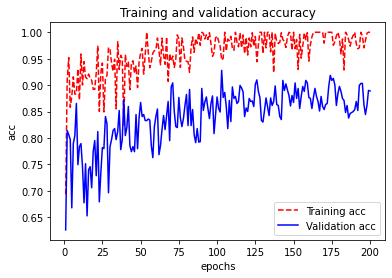

<Figure size 432x288 with 0 Axes>

In [ ]:
acc = train_auc
val_acc = val_auc

epochs   = range(1,len(acc)+1,1)

plt.plot ( epochs,     acc, 'r--', label='Training acc'  )
plt.plot ( epochs, val_acc,  'b', label='Validation acc')
plt.title ('Training and validation accuracy')
plt.ylabel('acc')
plt.xlabel('epochs')

plt.legend()
plt.figure()

<Figure size 432x288 with 0 Axes>

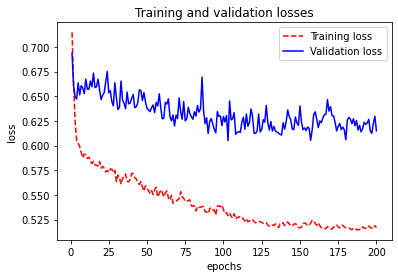

<Figure size 432x288 with 0 Axes>

In [ ]:
acc = train_losses
val_acc = test_losses

epochs   = range(1,len(acc)+1,1)

plt.plot ( epochs,     acc, 'r--', label='Training loss'  )
plt.plot ( epochs, val_acc,  'b', label='Validation loss')
plt.title ('Training and validation losses')
plt.ylabel('loss')
plt.xlabel('epochs')

plt.legend()
plt.figure()

In [ ]:
accuracy_dataframe = pd.DataFrame({"train_auc":train_auc, "val_auc":val_auc})
accuracy_dataframe.to_csv(dataframes_path + "Pesos Vgg16/AccuracyDataframe.csv", index=False)
losses_dataframe = pd.DataFrame({"train_auc":train_losses, "val_auc":test_losses})
losses_dataframe.to_csv(dataframes_path +"Pesos Vgg16/LossesDataFrame.csv", index=False)

In [ ]:
accuracy_dataframe.sort_values(by=['val_auc'], ascending=False)

,train_auc,val_auc
102,0.947214,0.927894
173,1.000000,0.918406
175,0.975369,0.912713
125,0.944118,0.909867
157,0.985986,0.908918
...,...,...
22,0.850440,0.679317
12,0.944444,0.677419
4,0.878543,0.667932
14,0.912109,0.652751


In [ ]:
# Batch size for training (change depending on how much memory you have)
# You should use a power of 2.
batch_size = 16

In [ ]:
model = Melanoma_Net(cnn_model_name = model_name, num_classes = num_classes) 
checkpoint = torch.load(dataframes_path + 'Pesos Vgg16/vgg16_weights_195.pt')
# checkpoint = torch.load(dataframes_path + 'Pesos Vgg16/vgg16_weights_195.pt',map_location ='cpu')

model.load_state_dict(checkpoint['state_dict'])

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = ("cpu")

input_size = model.input_size 
dataloaders = get_dataloaders(input_size, batch_size, shuffle = shuffle_datasets) 
test_loader = dataloaders['test']

if torch.cuda.is_available(): model.cuda()
    
model.eval()

fn_list = [] 
pred_list = []

for inputs, features, fn in test_loader: 
    inputs = inputs.to(device) 
    features = features.to(device) 
    output = model(inputs, features) 
    pred = (output > 0).type(torch.float64) 
    #print(pred)
    fn_list += fn 
    pred_list += [p.item() for p in pred]

In [ ]:
submission = pd.DataFrame({"image_name":fn_list, "target":pred_list})
submission.to_csv(dataframes_path + "Submission.csv", index=False)

In [ ]:
df_test = pd.read_csv(dataframes_path + "test.csv")
df_merge = pd.merge(df_test, submission, left_index=True, right_index=True)

print("------------Matriz de confusión-------------------")
print(confusion_matrix(df_merge['target_x'], df_merge['target_y']))

print("------------Exactitud-------------------")
print(accuracy_score(df_merge['target_x'], df_merge['target_y']))

print("------------Precision-------------------")
print(precision_score(df_merge['target_x'], df_merge['target_y'], average='weighted'))
print(precision_score(df_merge['target_x'], df_merge['target_y'], average=None))

print("------------Sensibilidad-------------------")
print(recall_score(df_merge['target_x'], df_merge['target_y'], average='weighted'))
print(recall_score(df_merge['target_x'], df_merge['target_y'], average=None))

print("------------F1 score-------------------")
print(f1_score(df_merge['target_x'], df_merge['target_y'], average='weighted'))
print(f1_score(df_merge['target_x'], df_merge['target_y'], average=None))

------------Matriz de confusión-------------------
[[230  48]
 [ 68 195]]
------------Exactitud-------------------
0.7855822550831792
------------Precision-------------------
0.7867156027824604
[0.77181208 0.80246914]
------------Sensibilidad-------------------
0.7855822550831792
[0.82733813 0.74144487]
------------F1 score-------------------
0.7850672805366208
[0.79861111 0.77075099]
